In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)

# doc2vec
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from sklearn.base import BaseEstimator

# Stratified sampling for multi-label classification
from skmultilearn.model_selection import IterativeStratification

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [4]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth one world leading online betting gaming company org...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [5]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [6]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

def iterative_train_test_split(X, y, test_size):
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X.iloc[train_indexes], y[train_indexes, :]
    X_test, y_test = X.iloc[test_indexes], y[test_indexes, :]

    return X_train, y_train, X_test, y_test

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_tokenized'], Y, test_size=0.2)

## 2. Define doc2vec model
Define a class with fit, transform, and fit_transform to be able to use the model in pipeline. 

Standard parameters:
- dm=1: ‘distributed memory’ (PV-DM): Preserves the word order in a document
- vector_size=100
- window=5: The maximum distance between the current and predicted word within a sentence
- negative=5: Negative sampling with 5 noise words
- min_count=5: Ignores all words with total frequency lower than this
- alpha=0.025: Initial learning rate
- min_alpha=0.0001: Learning rate will linearly drop to min_alpha as training progresses
- epochs=10: Number of iterations (epochs) over the corpus

In [8]:
class Doc2VecModel(BaseEstimator):

    def __init__(self, dm=1, vector_size=1, window=1, epochs=1):
        self.d2v_model = None
        self.vector_size = vector_size
        self.window = window
        self.dm = dm
        self.epochs = epochs

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.d2v_model = Doc2Vec(vector_size=self.vector_size, window=self.window, dm=self.dm, epochs=self.epochs)
        # Tag docs
        tagged_documents = []
        for index, row in raw_documents.iteritems():
            tag = '{}_{}'.format("type", index)
            tokens = row.split()
            tagged_documents.append(TaggedDocument(words=tokens, tags=[tag]))
        # Build vocabulary
        self.d2v_model.build_vocab(tagged_documents)
        # Train model
        self.d2v_model.train(tagged_documents, total_examples=len(tagged_documents), epochs=self.d2v_model.epochs)
        return self

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
            X.append(self.d2v_model.infer_vector(row.split()))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X

    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)

## 3. Replicate classification performed in NLP for SDGs paper
Parameters:
- dm=0: distributed bag of words (PV-DBOW)
- vector_size=100
- negative=5
- epochs=30

In [17]:
np.random.seed(7)

pipeline = Pipeline([
    ('doc2vec', Doc2VecModel(dm=0, vector_size=100, window=5, epochs=30)), 
    ('clf', OneVsRestClassifier(SVC(kernel='linear')))
])

parameters = {
    'clf__estimator__C': [0.1, 1, 10]
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...............................clf__estimator__C=10; total time=56.3min
[CV] END ..............................clf__estimator__C=0.1; total time=58.9min
[CV] END ..............................clf__estimator__C=0.1; total time=59.7min
[CV] END ..............................clf__estimator__C=0.1; total time=59.8min
[CV] END ................................clf__estimator__C=1; total time=60.3min
[CV] END ...............................clf__estimator__C=10; total time=60.1min
[CV] END ..............................clf__estimator__C=0.1; total time=60.6min
[CV] END ..............................clf__estimator__C=0.1; total time=60.7min
[CV] END ................................clf__estimator__C=1; total time=60.7min
[CV] END ................................clf__estimator__C=1; total time=61.1min
[CV] END ................................clf__estimator__C=1; total time=61.2min
[CV] END ...............................clf__esti

              precision    recall  f1-score   support

           0       0.72      0.37      0.49       198
           1       0.79      1.00      0.88      1499
           2       0.76      1.00      0.87      1442
           3       0.75      0.96      0.84      1314
           4       0.80      0.95      0.87      1414
           5       0.77      0.92      0.84      1317
           6       0.75      0.92      0.83      1220
           7       0.68      0.36      0.47       191
           8       0.82      1.00      0.90      1544
           9       0.75      0.79      0.77      1151
          10       0.68      0.62      0.65       559
          11       0.74      0.92      0.83      1248
          12       0.68      0.36      0.47       191

   micro avg       0.77      0.91      0.83     13288
   macro avg       0.75      0.78      0.75     13288
weighted avg       0.77      0.91      0.82     13288
 samples avg       0.76      0.90      0.80     13288



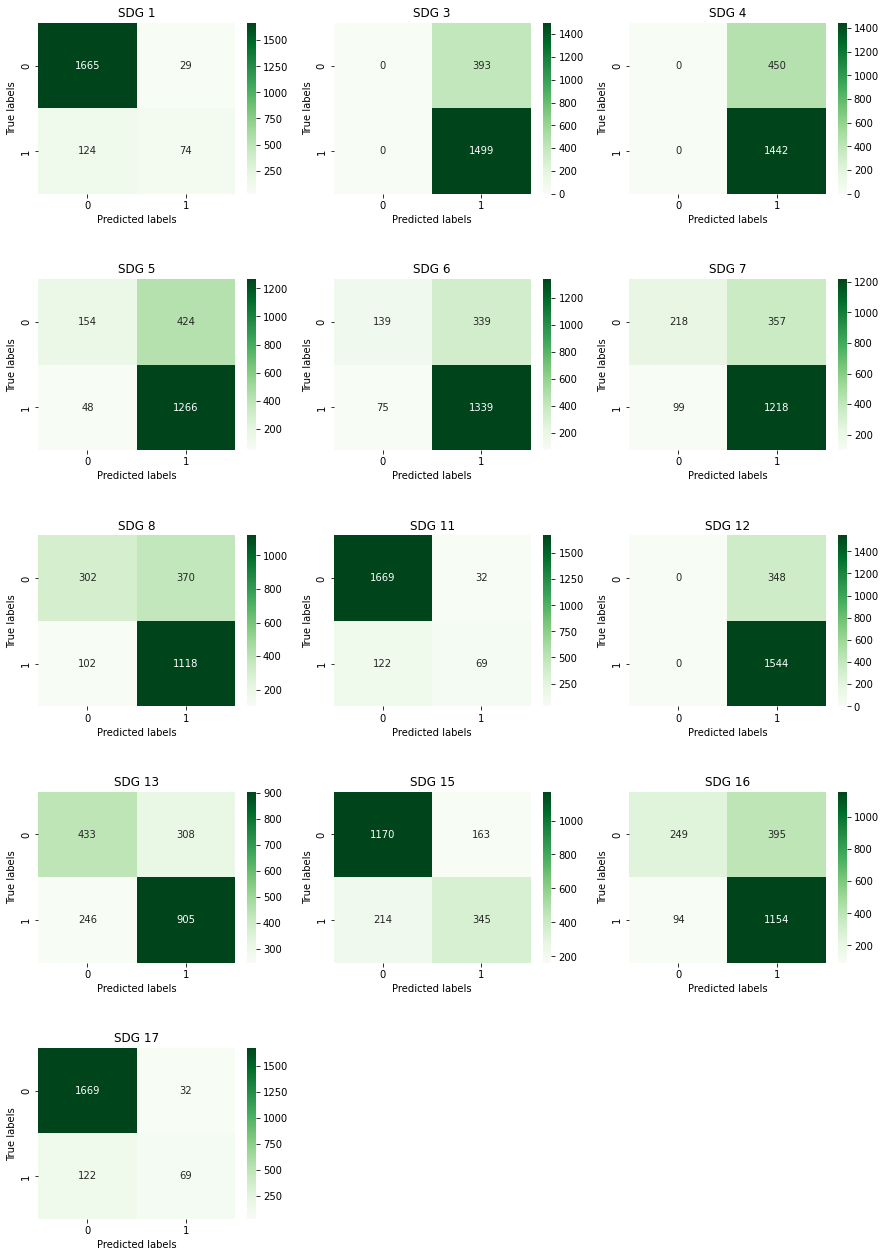

In [18]:
evaluation(grid_svm, X_test, Y_test)

In [19]:
np.random.seed(7)

pipeline = Pipeline([
    ('doc2vec', Doc2VecModel(dm=0, vector_size=100, window=5, epochs=30)), 
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])

parameters = {
    'clf__estimator__C': [0.1, 1, 10]
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................clf__estimator__C=1; total time=56.1min
[CV] END ..............................clf__estimator__C=0.1; total time=56.3min
[CV] END ..............................clf__estimator__C=0.1; total time=57.2min
[CV] END ..............................clf__estimator__C=0.1; total time=57.4min
[CV] END ..............................clf__estimator__C=0.1; total time=57.7min
[CV] END ................................clf__estimator__C=1; total time=57.7min
[CV] END ..............................clf__estimator__C=0.1; total time=57.9min
[CV] END ................................clf__estimator__C=1; total time=57.9min
[CV] END ................................clf__estimator__C=1; total time=57.9min
[CV] END ................................clf__estimator__C=1; total time=57.9min
[CV] END ...............................clf__estimator__C=10; total time=58.3min
[CV] END ...............................clf__esti

              precision    recall  f1-score   support

           0       0.38      0.79      0.52       198
           1       0.91      0.69      0.79      1499
           2       0.89      0.65      0.75      1442
           3       0.88      0.73      0.79      1314
           4       0.91      0.66      0.77      1414
           5       0.86      0.67      0.75      1317
           6       0.85      0.78      0.81      1220
           7       0.37      0.77      0.50       191
           8       0.94      0.65      0.77      1544
           9       0.84      0.59      0.69      1151
          10       0.59      0.71      0.65       559
          11       0.85      0.69      0.76      1248
          12       0.37      0.77      0.50       191

   micro avg       0.81      0.68      0.74     13288
   macro avg       0.74      0.70      0.70     13288
weighted avg       0.85      0.68      0.75     13288
 samples avg       0.76      0.65      0.66     13288



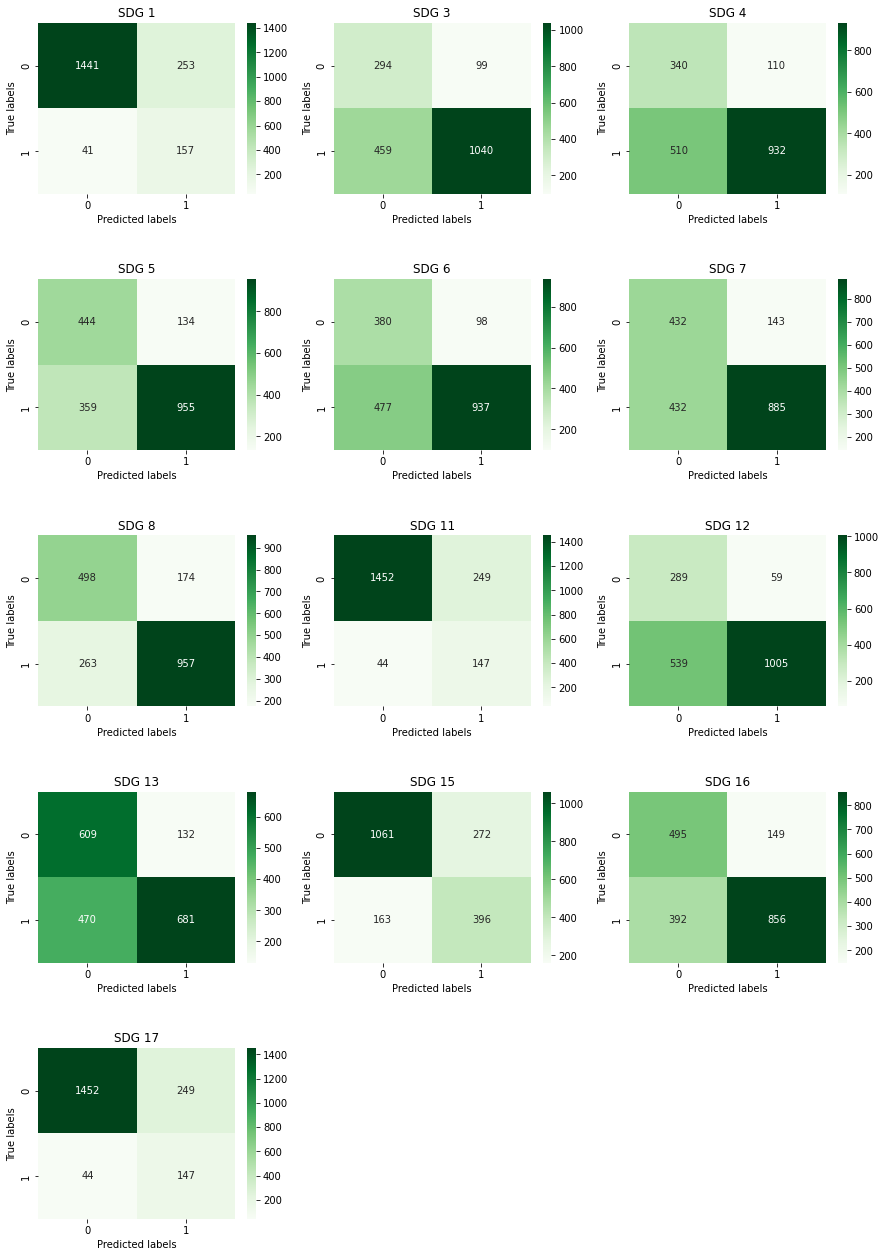

In [20]:
evaluation(grid_svm, X_test, Y_test)

In [18]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('doc2vec', Doc2VecModel(dm=0, vector_size=100, window=5, epochs=30)), 
    ('smote', SMOTE()), 
    ('clf', SVC(kernel='linear'))
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')

# Grid Search
grid_svm = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'estimator__clf__C': 10}
Mean cross-validated F1-score of the best estimator: 0.8032875593202808


              precision    recall  f1-score   support

           0       0.41      0.75      0.53       198
           1       0.91      0.69      0.79      1499
           2       0.88      0.64      0.74      1442
           3       0.88      0.71      0.79      1314
           4       0.91      0.63      0.75      1414
           5       0.88      0.64      0.74      1317
           6       0.84      0.76      0.80      1220
           7       0.37      0.70      0.48       191
           8       0.93      0.64      0.76      1544
           9       0.84      0.58      0.69      1151
          10       0.59      0.73      0.65       559
          11       0.86      0.69      0.76      1248
          12       0.37      0.70      0.48       191

   micro avg       0.81      0.67      0.74     13288
   macro avg       0.74      0.68      0.69     13288
weighted avg       0.85      0.67      0.74     13288
 samples avg       0.76      0.63      0.65     13288



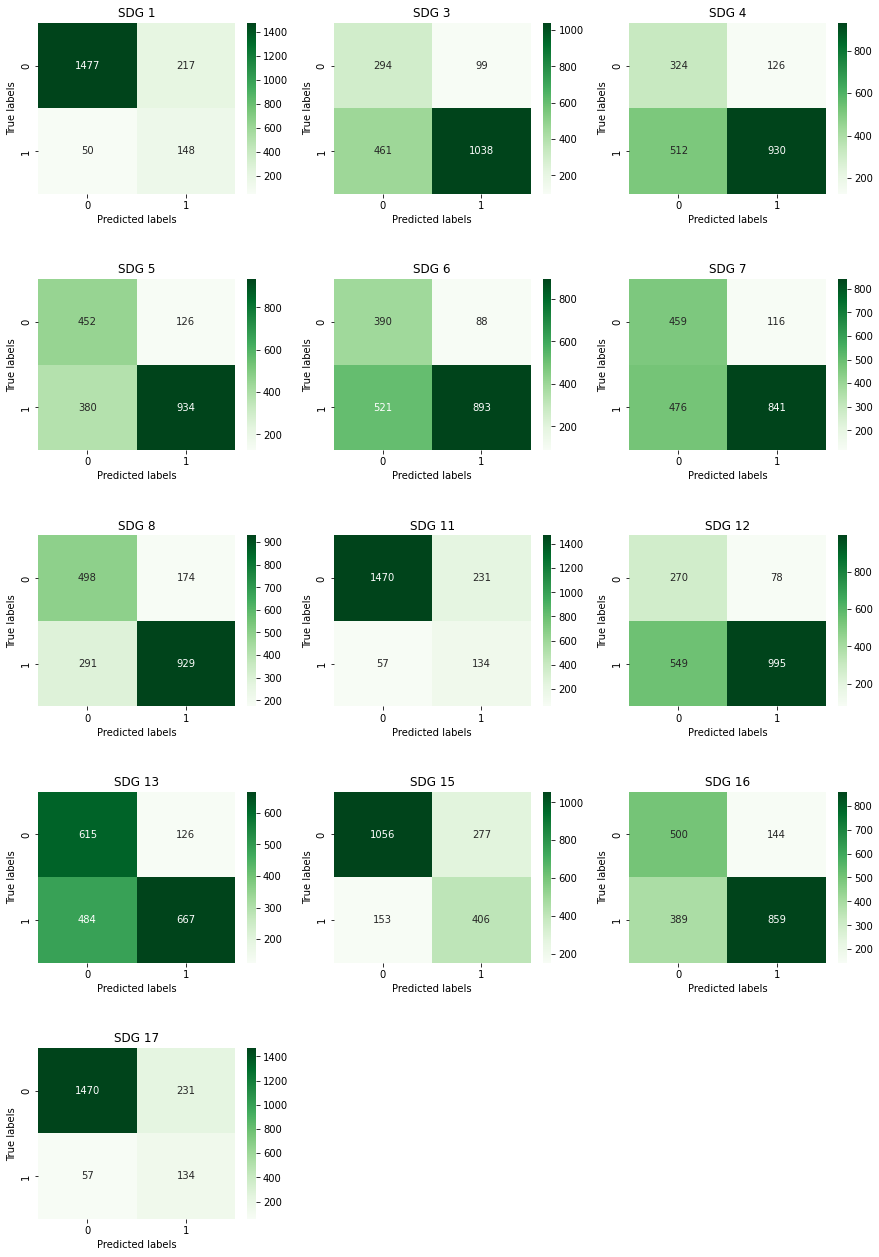

In [25]:
evaluation(grid_svm, X_test, Y_test)

## 4. Run Grid Search to find best model

In [26]:
np.random.seed(7)

pipeline = Pipeline([
    ('doc2vec', Doc2VecModel(dm=1, window=5, epochs=30)), # ‘distributed memory’ (PV-DM): Preserves the word order in a document
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])

parameters = {
    'doc2vec__vector_size': [50, 100, 200, 500],
    'clf__estimator__C': [0.1, 1, 10]
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....clf__estimator__C=0.1, doc2vec__vector_size=100; total time=95.2min
[CV] END ......clf__estimator__C=1, doc2vec__vector_size=100; total time=87.2min
[CV] END .....clf__estimator__C=1, doc2vec__vector_size=500; total time=182.2min
[CV] END .....clf__estimator__C=0.1, doc2vec__vector_size=50; total time=75.9min
[CV] END .......clf__estimator__C=1, doc2vec__vector_size=50; total time=84.1min
[CV] END .....clf__estimator__C=1, doc2vec__vector_size=200; total time=112.2min
[CV] END ....clf__estimator__C=10, doc2vec__vector_size=100; total time=152.1min
[CV] END ....clf__estimator__C=0.1, doc2vec__vector_size=200; total time=97.9min
[CV] END ......clf__estimator__C=1, doc2vec__vector_size=100; total time=90.5min
[CV] END .....clf__estimator__C=1, doc2vec__vector_size=500; total time=239.4min
[CV] END ....clf__estimator__C=0.1, doc2vec__vector_size=200; total time=98.7min
[CV] END ......clf__estimator__C=1, doc2vec__vec

              precision    recall  f1-score   support

           0       0.41      0.69      0.51       198
           1       0.90      0.64      0.75      1499
           2       0.87      0.62      0.72      1442
           3       0.87      0.67      0.76      1314
           4       0.90      0.66      0.76      1414
           5       0.90      0.57      0.70      1317
           6       0.85      0.70      0.77      1220
           7       0.40      0.69      0.51       191
           8       0.94      0.63      0.76      1544
           9       0.82      0.58      0.68      1151
          10       0.57      0.76      0.65       559
          11       0.85      0.65      0.74      1248
          12       0.40      0.69      0.51       191

   micro avg       0.81      0.64      0.72     13288
   macro avg       0.74      0.66      0.68     13288
weighted avg       0.85      0.64      0.72     13288
 samples avg       0.75      0.60      0.63     13288



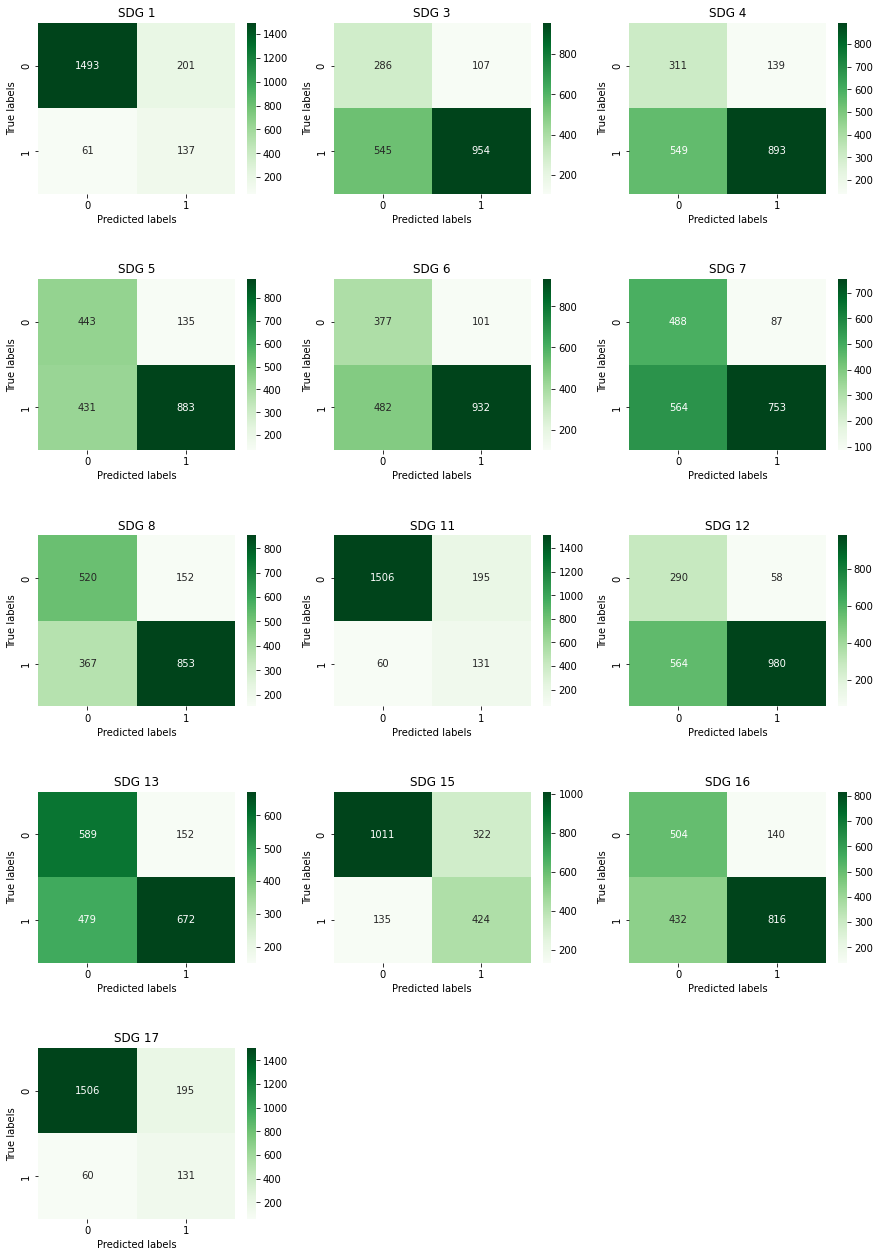

In [28]:
evaluation(grid_svm, X_test, Y_test)